## Importing libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import tensorflow
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

from google.colab import drive
drive.mount('/content/drive')

# To get reproducible results
from numpy.random import seed 
seed(0) 
tensorflow.random.set_seed(0)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#install the required libraries
!pip install pmdarima
!pip install statsmodels --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Importing the dataset

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Biogas RMS project/Datasets/Lab dataset/reactor1_biogas.csv', index_col="day", parse_dates=True)
df = df["reactor1"]
df.head()

day
0      0
1    100
2    120
3    100
4    100
Name: reactor1, dtype: int64

## Plotting the biogas values
This section takes a look at the trend in the biogas values.

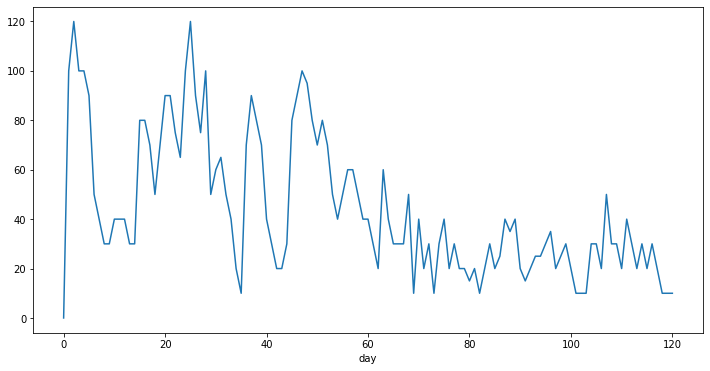

In [ ]:
df.plot(figsize=(12,6))

### Decomposing the plot
Using seasonal-decompose to find a trend, seasonal changes and noise in the plot.

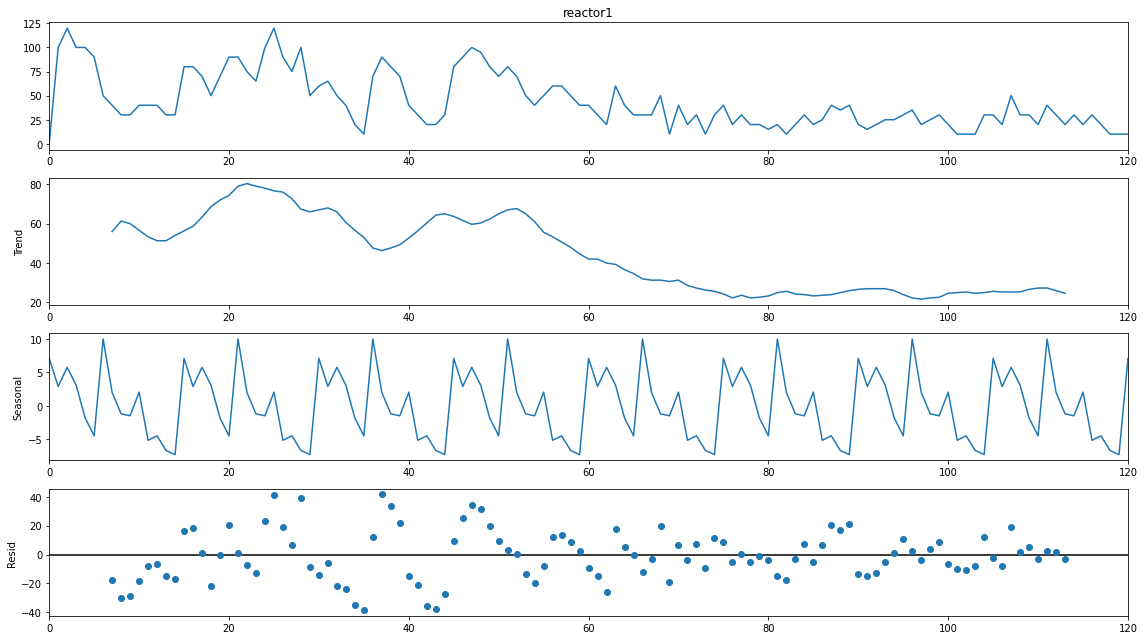

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
results = seasonal_decompose(x=df, period = 15, model='additive')
decompose_plot = results.plot();
decompose_plot.set_size_inches((16, 9))
# Tight layout to realign things
decompose_plot.tight_layout()
decompose_plot.show()

## Check if the data is stationary
*In statistics and time series analysis, a time series is said to be stationary if its statistical properties, such as the mean and variance, are constant over time. In other words, a stationary time series has no trend or seasonality, and its statistical properties do not change over time. Stationarity is an important assumption in many time series models, and is often required for the model to be effective.*

In [ ]:
from pmdarima.arima import ADFTest
adf_test = ADFTest(alpha = 0.05)
adf_test.should_diff(df)

(0.01, False)

## Selecting the best model
`auto_arima` can be used to select the best model and its parameters.

Auto arima suggests best model and parameters based on  **AIC metric** (relative quality of statistical models)

*The Akaike information criterion (AIC) is a metric used to evaluate the quality of a statistical model. It is based on the likelihood function of the model, and takes into account the number of parameters in the model. The AIC metric provides a way to compare different models and choose the one that is most appropriate for a given dataset.*

Autoarima gives us the best model suited for the data
* p - number of autoregressive terms (AR)
* q - Number of moving avergae terms (MA)
* d - number of non-seasonal differences
* p, d, q represent non-seasonal components
* P, D, Q represent seasonal components

In [ ]:
from pmdarima.arima import auto_arima

arima_model = auto_arima(df, start_p = 1, d=1, start_q = 1, 
                          max_p = 5, max_q = 5, max_d=5, m = 12, 
                          start_P = 0, D=1, start_Q=0, max_P=5, max_D=5, max_Q=5,
                          seasonal = True, 
                          trace = True, 
                          error_action ='ignore',   
                          suppress_warnings = True,  
                          stepwise = True, n_fits=50) 
print(arima_model.summary() )

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=inf, Time=0.52 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1010.438, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=991.988, Time=0.15 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=975.205, Time=0.31 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1010.825, Time=0.07 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=976.838, Time=0.50 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=976.651, Time=1.19 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=991.880, Time=0.13 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=977.999, Time=2.57 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=973.904, Time=0.29 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=975.429, Time=0.45 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=975.210, Time=0.85 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=990.240, Time=0.16 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=inf, Time=1.46 sec
 ARIMA(1,1,0)(0,1,1)[12]             : 

### Best model selected: 
SARIMAX(0, 1, 0)x(0, 1, [1], 12)

## Splitting into train and test set
This needs to be done sequentially.

In [ ]:
# Setting a fraction for train data
train_fraction = 0.7
train_size = (int)(len(df)*train_fraction)

# Splitting the train and test data
X_train = df[0:train_size]
X_test = df[train_size :]

# Building the ARIMA based model

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX 
model = SARIMAX(X_train,  
                order = (0, 1, 0),  
                seasonal_order =(0, 1, 1, 12)) 

sarimax = model.fit()

### Plotting the train and test values

[[  0.]
 [  0.]
 [100.]
 [120.]
 [100.]]
[[  0]
 [100]
 [120]
 [100]
 [100]]


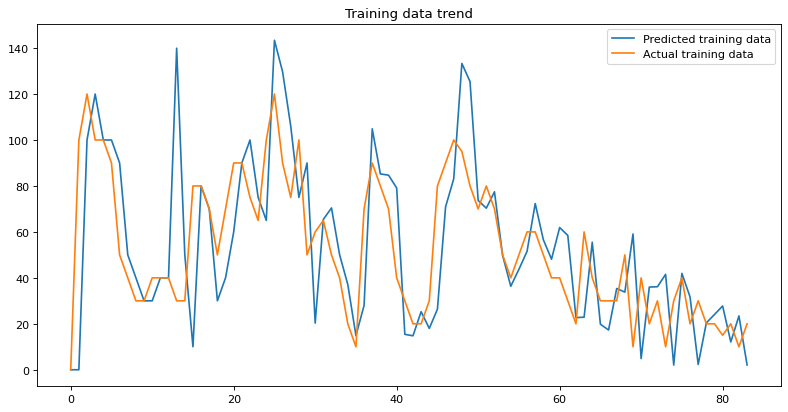

In [ ]:
# TRAINING DATA

# Making predctions and taking inverse transform
predicted_train = np.transpose([sarimax.predict(0, len(X_train)-1).to_numpy()])
actual_train = np.transpose([X_train])

# Plotting the result
figure(figsize=(12, 6), dpi=80)
plt.plot(predicted_train, label='Predicted training data')
plt.plot(actual_train, label='Actual training data')
plt.legend()
plt.title("Training data trend")
plt.show()

(37, 1)
(37, 1)


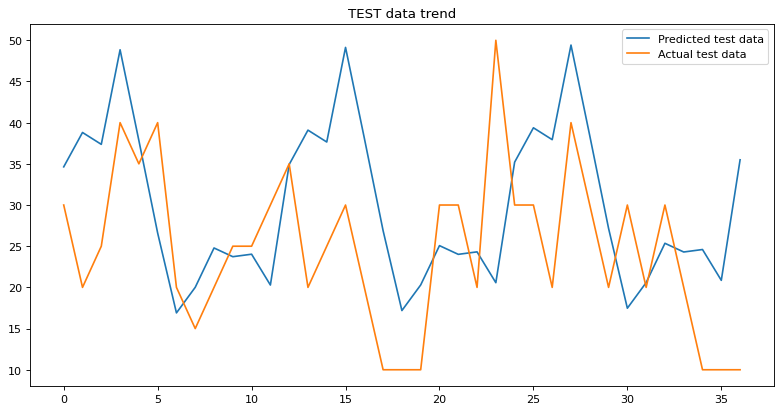

In [ ]:
# TEST DATA

# Making predctions and taking inverse transform
predicted_test = np.transpose([sarimax.predict(len(X_train), len(df)-1).to_numpy()])
actual_test = np.transpose([X_test])

# Plotting the result
figure(figsize=(12, 6), dpi=80)
plt.plot(predicted_test, label='Predicted test data')
plt.plot(actual_test, label='Actual test data')
plt.legend()
plt.title("TEST data trend")
plt.show()

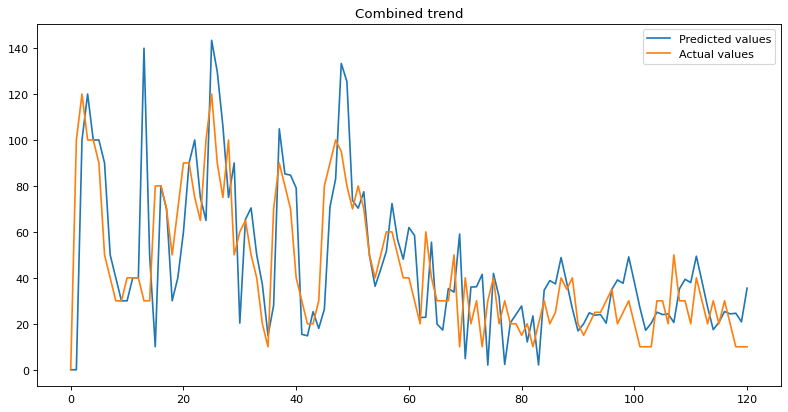

In [ ]:
# COMBINED PLOT
# Total loss in datapoints  = 2*(sequence_size + 1)

# Making predctions and taking inverse transform
predicted_combined = np.vstack([predicted_train, predicted_test])
actual_combined = np.vstack([actual_train, actual_test])

# Plotting the result
figure(figsize=(12, 6), dpi=80)
plt.plot(predicted_combined, label='Predicted values')
plt.plot(actual_combined, label='Actual values')
plt.legend()
plt.title("Combined trend")
plt.show()